In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, Flatten, TimeDistributed
from tensorflow.keras.layers import Dropout, Bidirectional, LSTM, Attention, Multiply, Reshape, Permute, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

T = 200
tau = 3


with open('Data/Feature/k_data (200, {})'.format(tau), 'rb') as f:
    k_data = pickle.load(f)

with open("Data/Feature/Trajectories ({})".format(T),"rb") as f:
    trajectories = pickle.load(f)

In [2]:
input_data = trajectories

In [3]:
input_data = trajectories
train_input = np.zeros((300000,T,2))
val_input = np.zeros((60000,T,2))
test_input = np.zeros((60000,T,2))

train_output = np.zeros((300000,T))
val_output = np.zeros((60000,T))
test_output = np.zeros((60000,T))

cases = ['single', 'multi', 'immobile', 'dimerization','confinement']


for case_num, case in enumerate(cases):
    ns_t = int(case_num*60000)
    ne_t = int((case_num+1)*60000)

    ns_v = int(case_num*12000)
    ne_v = int((case_num+1)*12000)

    train_input[ns_t:ne_t,:,0] = input_data['x'][case][0]
    train_input[ns_t:ne_t,:,1] = input_data['y'][case][0]
    val_input[ns_v:ne_v,:,0] = input_data['x'][case][1]
    val_input[ns_v:ne_v,:,1] = input_data['y'][case][1]
    test_input[ns_v:ne_v,:,0] = input_data['x'][case][2]
    test_input[ns_v:ne_v,:,1] = input_data['y'][case][2]
    
    train_output[ns_t:ne_t] = k_data[case][0]
    val_output[ns_v:ne_v] = k_data[case][1]
    test_output[ns_v:ne_v] = k_data[case][2]
        
        




    
print('train_input shape = {}'.format(train_input.shape))
print('train_output shape = {}'.format(train_output.shape))
print('val_input shape = {}'.format(val_input.shape))
print('val_output shape = {}'.format(val_output.shape))

train_input shape = (300000, 200, 2)
train_output shape = (300000, 200)
val_input shape = (60000, 200, 2)
val_output shape = (60000, 200)


In [4]:
from tensorflow.keras.callbacks import Callback

class ValLossHistory(Callback):
    def __init__(self):
        super().__init__()
        self.val_loss_list = []

    def on_epoch_end(self, epoch, logs=None):
        # logs['val_loss']를 리스트에 추가
        if logs is not None and 'val_loss' in logs:
            self.val_loss_list.append(logs['val_loss'])

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, Flatten, TimeDistributed
from tensorflow.keras.layers import Dropout, Bidirectional, LSTM, Attention, Multiply, Reshape, Permute, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

for f_num in range(0,1):
    T = 200
    kernel_size= 3
    model_path = 'Models/' + 'trajectories_model_k_(12.05) (T = {}, ks = {}, 3_cnn, causal).hdf5'.format(T, kernel_size)

    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', mode = 'min',\
                                    verbose=1, save_best_only=True)
    cb_early_stopping = EarlyStopping(monitor='val_loss', mode = 'min', patience= 20)

    # Compile model

    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience= 2, min_lr=1e-7, \
                            verbose=1, min_delta=1e-5)


    l1 = 1e-5
    l2 = 1e-4
    lr = 1e-3
    
    strides=1
    activation='relu'

    inputs = Input(shape=(T,2), name='input1')
    

    
  
    
    x = Conv1D(512, kernel_size=kernel_size, padding = 'causal')(inputs)
    x = BatchNormalization()(x)
    x = Conv1D(512, kernel_size=kernel_size, padding = 'causal')(x)
    x = BatchNormalization()(x)
    x = Conv1D(512, kernel_size=kernel_size, padding = 'causal')(x)
    x = BatchNormalization()(x)



    x = Bidirectional(LSTM(1024, activation='tanh', return_sequences=True))(x)
    x = BatchNormalization()(x)

    x = Bidirectional(LSTM(512, activation='tanh', return_sequences=True))(x)
    x = BatchNormalization()(x)

    x = Bidirectional(LSTM(256, activation='tanh', return_sequences=False))(x)

    
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    outputs = Dense(
            200,
            activation=activation,
            kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)
        )(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.summary()


    model.compile(optimizer= Adam(lr),
                      loss='mae')

 

    val_loss_history = ValLossHistory()
    
    history = model.fit(train_input, train_output, epochs = 1000, batch_size= 500, verbose=1, \
                               validation_data=(val_input, val_output),callbacks=[cb_checkpoint, cb_early_stopping, rlr, val_loss_history])


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input1 (InputLayer)          [(None, 200, 2)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 512)          3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 512)          2048      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 512)          786944    
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 512)          2048      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 512)          786944    
_________________________________________________________________
batch_normalization_2 (Batch (None, 200, 512)          2048  

In [6]:
# from tensorflow import keras
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, Flatten, TimeDistributed
# from tensorflow.keras.layers import Dropout, Bidirectional, LSTM, Attention, Multiply, Reshape, Permute, Dense
# from tensorflow.keras import regularizers
# from tensorflow.keras.backend import clear_session
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# import pickle
# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow as tf

# T = 200
# kernel_size= 3
# model_path = 'Models/' + 'trajectories_model_k_(12.05) (T = {}, ks = {}, 2_cnn).hdf5'.format(T, kernel_size)
# model = keras.models.load_model(model_path)


# cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', mode = 'min',\
#                                     verbose=1, save_best_only=True)
# cb_early_stopping = EarlyStopping(monitor='val_loss', mode = 'min', patience= 20)

#     # Compile model

# rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience= 2, min_lr=1e-7, \
#                             verbose=1, min_delta=1e-5)

# lr = 1e-3
# model.compile(optimizer= Adam(lr),
#                       loss='mae')
# val_loss_history = ValLossHistory()
    
# history = model.fit(train_input, train_output, epochs = 1000, batch_size= 500, verbose=1, \
#                                validation_data=(val_input, val_output),callbacks=[cb_checkpoint, cb_early_stopping, rlr, val_loss_history])


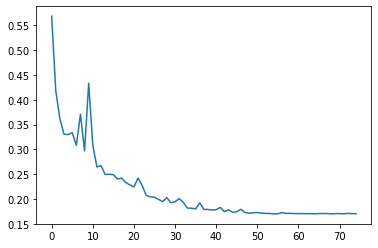

In [7]:
plt.plot(val_loss_history.val_loss_list)

In [8]:
with open('learning curve(val_loss)/trajectories_model_k_(12.05) (T = {}, ks = {}, 2_cnn, causal)'.format(T, tau), 'wb') as f:
    pickle.dump(val_loss_history.val_loss_list, f)

In [3]:
import pickle
import matplotlib.pyplot as plt
T = 200
kernel_size = 3
with open('learning curve(val_loss)/trajectories_model_k_(12.05) (T = {}, ks = {}, 1_cnn, causal)'.format(T, kernel_size), mode='rb') as f:
    val_loss1 = pickle.load(f)
    
with open('learning curve(val_loss)/trajectories_model_k_(12.05) (T = {}, ks = {}, 2_cnn, causal)'.format(T, kernel_size), mode='rb') as f:
    val_loss2 = pickle.load(f)
    
with open('learning curve(val_loss)/trajectories_model_k_(12.05) (T = {}, ks = {}, 3_cnn, causal)'.format(T, kernel_size), mode='rb') as f:
    val_loss3 = pickle.load(f)

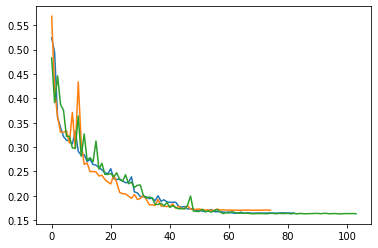

In [4]:
plt.plot(val_loss1)
plt.plot(val_loss2)
plt.plot(val_loss3)

In [6]:
import numpy as np

print(np.min(val_loss1))
print(np.min(val_loss2))
print(np.min(val_loss3))

0.1639029085636139
0.16978459060192108
0.1626293957233429


In [7]:

import pickle
import matplotlib.pyplot as plt
with open('learning curve(val_loss)/trajectories_model_k_(12.05) (T = {}, ks = {}, 1_cnn)'.format(T, kernel_size), mode='rb') as f:
    val_loss1 = pickle.load(f)
    
with open('learning curve(val_loss)/trajectories_model_k_(12.05) (T = {}, ks = {}, 2_cnn)'.format(T, kernel_size), mode='rb') as f:
    val_loss2 = pickle.load(f)
    
with open('learning curve(val_loss)/trajectories_model_k_(12.05) (T = {}, ks = {}, 3_cnn)'.format(T, kernel_size), mode='rb') as f:
    val_loss3 = pickle.load(f)

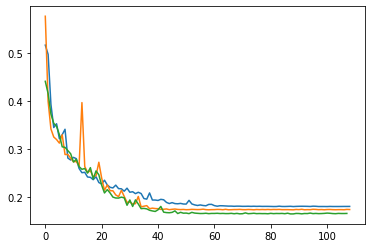

In [8]:
plt.plot(val_loss1)
plt.plot(val_loss2)
plt.plot(val_loss3)

In [9]:
print(np.min(val_loss1))
print(np.min(val_loss2))
print(np.min(val_loss3))

0.18015508353710175
0.173323854804039
0.16478103399276733
